In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from highlight_text import ax_text, fig_text

In [10]:
# data = pd.read_csv('./combined_sentiment_labelled.tsv', sep='\t')

In [40]:
# data

In [21]:
# len(set([x for l in data.text.apply(lambda x: x.split(" ")).values for x in l]))

8018

https://www.tensorflow.org/tutorials/text/text_classification_rnn

In [86]:
dataset = tfds.load('imdb_reviews',
                    as_supervised=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (C:\Users\Dergel\tensorflow_datasets\imdb_reviews\plain_text\0.1.0)
INFO:absl:Constructing tf.data.Dataset for split None, from C:\Users\Dergel\tensorflow_datasets\imdb_reviews\plain_text\0.1.0


In [87]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [88]:
# for example, label in train_dataset.take(1):
#   print('text: ', example.numpy())
#   print('label: ', label.numpy())

In [89]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [90]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [143]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary())+2,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    history = model.fit(train_dataset, epochs=10,
                        validation_data=test_dataset, 
                        validation_steps=30)

Epoch 1/10
391/391 [==============================] - 508s 1s/step - loss: 0.6216 - accuracy: 0.6000 - val_loss: 0.4996 - val_accuracy: 0.7396
Epoch 2/10
391/391 [==============================] - 509s 1s/step - loss: 0.4142 - accuracy: 0.8123 - val_loss: 0.3585 - val_accuracy: 0.8542
Epoch 3/10
391/391 [==============================] - 520s 1s/step - loss: 0.3489 - accuracy: 0.8512 - val_loss: 0.3291 - val_accuracy: 0.8656
Epoch 4/10
391/391 [==============================] - 516s 1s/step - loss: 0.3270 - accuracy: 0.8606 - val_loss: 0.3225 - val_accuracy: 0.8682
Epoch 5/10
391/391 [==============================] - 478s 1s/step - loss: 0.3184 - accuracy: 0.8665 - val_loss: 0.3280 - val_accuracy: 0.8708
Epoch 6/10
 76/391 [====>.........................] - ETA: 6:08 - loss: 0.3272 - accuracy: 0.8610

----

In [118]:
sample_text

'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'

In [121]:
tokens = sample_text.split(" ")
probs = []
for k in range(0,len(tokens)):
    probs.append(model.predict(np.array([" ".join(tokens[:k+1])]))[0][0])

https://stackoverflow.com/questions/287871/how-to-print-colored-text-in-python

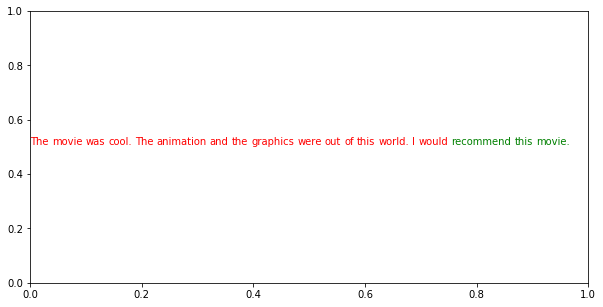

In [142]:
ig, ax = plt.subplots(figsize=(10,5))
ax_text(x = 0, y = 0.5,
        s = "<" + "> <".join(tokens) + ">",
        color = 'k', highlight_colors = ["red" if p < 0 else "green" for p in probs])

plt.show()